# News articles topic modelling

The dataset contains text from news articles. This task involves building a pipeline which can transform the text into a format which can be handled by a machine learning model and working out a number of news article types are present in the dataset.

Finding out the dataset contains 133 duplicates which should to be removed

In [1]:
import pandas as pd
news_data = pd.read_csv('news.csv', sep='\t')
print(news_data.head())
print()
print(f"Number of duplicates: {news_data.duplicated().sum()}")

                                               story
0  Quarterly profits at US media giant TimeWarner...
1  The dollar has hit its highest level against t...
2  The owners of embattled Russian oil giant Yuko...
3  British Airways has blamed high fuel prices fo...
4  Shares in UK drinks and food firm Allied Domec...

Number of duplicates: 133


In [2]:
news_data = news_data.drop_duplicates()

Importing the Natural Language Toolkit library and downloading:

- stopwords: common words to remove (e.g. "and", "the"...)
- WordNet: for lemmatization
- punkt tokenizer

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sirderyl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sirderyl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sirderyl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Inspecting the most frequently appearing words in the dataset. All of the words in top 20 are either stop words or other words that do not add anything of value to the sentence meaning. These should be removed.

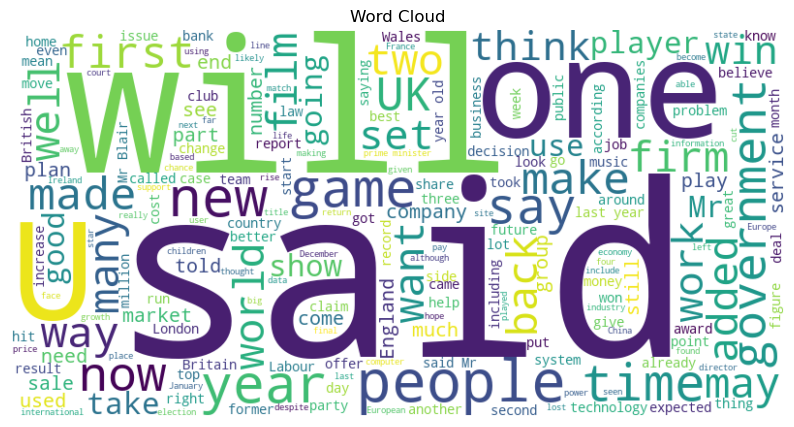

Top words:
the: 41826
to: 22963
of: 18525
and: 16769
a: 16141
in: 15443
is: 7922
for: 7914
that: 6987
The: 6719
on: 6614
was: 5674
be: 5338
with: 4740
has: 4641
it: 4595
said: 4586
have: 4437
as: 4320
at: 4104


In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

combined_text = " ".join(news_data['story'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud")
plt.show()

word_counts = Counter(combined_text.split())
top_words = word_counts.most_common(20)  # Adjust the number to get more or fewer top words
print("Top words:")
for word, count in top_words:
    print(f"{word}: {count}")

Preprocessing pipeline:

- removing stopwords and short words commonly appearing in the documents
- removing non-alphabetic characters
- tokenizes text into words
- lemmatizes words (reduces them to base form)

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from gensim.models import Phrases
from gensim.models.phrases import Phraser

def preprocess(texts):
    # Rwmoving stopwords + common words that do not add much meaning
    custom_stopwords = stopwords.words('english') + [
        'said', 'would', 'could', 'also', 'one', 'new', 'say', 'first', 'two',
        'make', 'made', 'like', 'way', 'well', 'many', 'get', 'set', 'may', 'want'
        ]
    
    # Better tokenization and lemmatization
    def process_text(text):
        # Remove numbers and special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        
        # Tokenize and lemmatize
        tokens = word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        
        # Remove stopwords and short words
        tokens = [lemmatizer.lemmatize(token) for token in tokens 
                 if token not in custom_stopwords and len(token) > 2]
        
        return tokens
    
    # Tokenize and preprocess all texts
    tokenized_texts = [process_text(text) for text in texts]

    # Create bigrams and trigrams
    bigram = Phrases(tokenized_texts, min_count=5, threshold=10)
    bigram_model = Phraser(bigram)

    trigram = Phrases(bigram[tokenized_texts], min_count=5, threshold=10)
    trigram_model = Phraser(trigram)

    # Apply the models
    text_with_bigrams = [bigram_model[text] for text in tokenized_texts]
    text_with_trigrams = [trigram_model[text] for text in text_with_bigrams]

    return text_with_trigrams

In [6]:
preprocessed_texts = preprocess(news_data['story'])

The top words are more meaningful after preprocessing, which should make topic clustering easier for the model

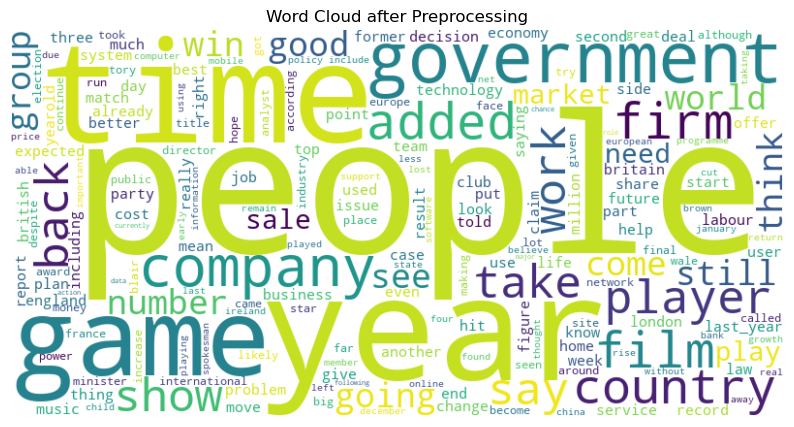

Top words after Preprocessing:
people: 1574
year: 1304
time: 1236
game: 1226
government: 1004
company: 973
firm: 780
film: 770
country: 706
added: 692
number: 624
back: 623
player: 622
show: 616
say: 610
good: 602
take: 587
still: 586
world: 583
work: 572


In [7]:
combined_text = " ".join([" ".join(text) for text in preprocessed_texts])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud after Preprocessing")
plt.show()

word_counts = Counter(combined_text.split())
top_words = word_counts.most_common(20)  # Adjust the number to get more or fewer top words
print("Top words after Preprocessing:")
for word, count in top_words:
    print(f"{word}: {count}")

Performing grid search over all combinations of LDA hyper-parameters to find the best model based on coherence score. Coherence evaluates the interpretability of topics by measuring semantic similarity between top words.

Using the 'optuna' library to make the grid search more effective, also by utilising multiple CPU cores. For optuna, hyperparameters are defined using 'trial' and training is started by creating an 'objective' and 'study' and using those to call 'optimize'.

In [8]:
from gensim import models
import numpy as np
from gensim.models import CoherenceModel
import optuna

def create_objective(corpus, id2word, preprocessed_texts):
    def objective(trial):
        # Defining hyperparameter search space
        num_topic = trial.suggest_categorical('num_topic', [5, 10, 15, 20])
        alpha = trial.suggest_categorical('alpha', ['symmetric', 'asymmetric', 0.1, 0.5])
        eta = trial.suggest_categorical('eta', ['symmetric', 'auto', 0.1, 0.5])
        passes = trial.suggest_int('passes', 10, 20)

        # Train the LDA model
        lda_model = models.LdaMulticore(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topic,
            alpha=alpha,
            eta=eta,
            passes=passes,
            random_state=42
        )

        # Evaluate the coherence score
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=preprocessed_texts,
            dictionary=id2word,
            coherence="c_v"
        )

        coherence_score = coherence_model.get_coherence()

        return coherence_score
    
    return objective

Evaluate the best LDA model using:

- silhouette score: measures how well topics separate documents
- perplexity: measures how well the model predicts new data (lower is better)
- coherence score: measures topic interpretability

In [9]:
from sklearn.metrics import silhouette_score
import numpy as np

def evaluate_lda_model(lda_model, corpus, texts, id2word):
    # Get document-topic matrix with fixed number of topics
    num_topics = lda_model.num_topics
    doc_topics = np.zeros((len(corpus), num_topics))
    
    # Fill the matrix
    for doc_idx, doc in enumerate(corpus):
        topic_dist = lda_model.get_document_topics(doc, minimum_probability=0)
        for topic_id, prob in topic_dist:
            doc_topics[doc_idx, topic_id] = prob
    
    # Calculate silhouette score
    topic_labels = doc_topics.argmax(axis=1)
    sil_score = silhouette_score(doc_topics, topic_labels)
    
    # Calculate perplexity
    perplexity = lda_model.log_perplexity(corpus)
    
    # Calculate coherence
    coherence = CoherenceModel(
        model=lda_model, 
        texts=texts, 
        dictionary=id2word, 
        coherence='c_v'
    ).get_coherence()
    
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Perplexity: {perplexity:.4f}")
    print(f"Coherence Score: {coherence:.4f}")
    
    return sil_score, perplexity, coherence, doc_topics

Visualizing the topic clusters by reducing document-topic distributions to 2D using t-SNE.

In [45]:
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

def plot_lda_clusters(lda_model, corpus):
    # Get document-topic matrix with fixed number of topics
    num_topics = lda_model.num_topics
    doc_topics = np.zeros((len(corpus), num_topics))
    
    # Fill the matrix
    for doc_idx, doc in enumerate(corpus):
        topic_dist = lda_model.get_document_topics(doc, minimum_probability=0)
        for topic_id, prob in topic_dist:
            doc_topics[doc_idx, topic_id] = prob
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    doc_topics_2d = tsne.fit_transform(doc_topics)

    dominant_topics = np.argmax(doc_topics, axis=1)

    colors = plt.cm.Set1(np.linspace(0, 1, num_topics))
    custom_cmap = ListedColormap(colors)
    
    # Plot clusters
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(doc_topics_2d[:, 0], doc_topics_2d[:, 1], 
               c=dominant_topics, cmap=custom_cmap)
    cbar = plt.colorbar(scatter, label='Topic', ticks=range(num_topics))
    cbar.set_ticklabels(range(num_topics))
    plt.title('t-SNE visualization of document clusters')
    plt.show()

    # Print cluster sizes
    unique, counts = np.unique(dominant_topics, return_counts=True)
    print("\nCluster sizes:")
    for topic_id, count in zip(unique, counts):
        print(f"Topic {topic_id}: {count} documents")

Calculating and visualizing similarity between topics using cosine similarity of term distributions

In [21]:
import seaborn as sns

def plot_topic_similarity(lda_model):
    topic_terms = lda_model.get_topics()
    similarity_matrix = np.zeros((lda_model.num_topics, lda_model.num_topics))
    
    for i in range(lda_model.num_topics):
        for j in range(lda_model.num_topics):
            similarity_matrix[i, j] = np.dot(topic_terms[i], topic_terms[j])
    
    plt.figure()
    sns.heatmap(similarity_matrix, annot=True, cmap='YlOrRd')
    plt.title('Topic Similarity Matrix')
    plt.show()

Extracting top words for each topic and displaying representative documents where each topic has the highest probability

In [12]:
# 1. Print top words for each topic
def print_topic_details(lda_model, corpus, data_lemmatized, num_words=10, num_docs=3):
    # Print top words
    print("Topics and their top words:")
    for idx, topic in enumerate(lda_model.print_topics(num_words=num_words)):
        print(f"\nTopic {idx + 1}:")
        # Extract and format words
        words = [(word.split('*')[1]).strip().replace('"', '') 
                 for word in topic[1].split(' + ')]
        print(f"Top words: {', '.join(words)}")
        
        # Get representative documents
        print("\nExample documents:")
        # Get topic distribution for all documents
        doc_topics = [lda_model.get_document_topics(doc) for doc in corpus]
        # Find documents where this topic has highest probability
        topic_docs = [(i, max(topics, key=lambda x: x[1])[1]) 
                     for i, topics in enumerate(doc_topics)
                     if max(topics, key=lambda x: x[1])[0] == idx]
        # Sort by probability
        topic_docs = sorted(topic_docs, key=lambda x: x[1], reverse=True)
        
        # Print top documents
        for doc_idx, prob in topic_docs[:num_docs]:
            print(f"\nDocument (probability: {prob:.2f}):")
            print(' '.join(data_lemmatized[doc_idx][:50]) + "...")
        
        print("-" * 80)

Preparing the data and training the LDA model

In [13]:
from gensim import corpora

id2word = corpora.Dictionary(preprocessed_texts)
corpus = [id2word.doc2bow(text) for text in preprocessed_texts]
objective = create_objective(corpus, id2word, preprocessed_texts)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters:")
print(study.best_params)

[I 2024-12-13 13:18:17,682] A new study created in memory with name: no-name-e5e0973e-36f8-4b8f-868e-9c254182b227
[I 2024-12-13 13:19:01,486] Trial 0 finished with value: 0.44319203935248785 and parameters: {'num_topic': 20, 'alpha': 'asymmetric', 'eta': 'symmetric', 'passes': 15}. Best is trial 0 with value: 0.44319203935248785.
[I 2024-12-13 13:19:40,065] Trial 1 finished with value: 0.43546482669542985 and parameters: {'num_topic': 10, 'alpha': 0.5, 'eta': 'symmetric', 'passes': 14}. Best is trial 0 with value: 0.44319203935248785.
[I 2024-12-13 13:20:15,877] Trial 2 finished with value: 0.4856515315915333 and parameters: {'num_topic': 5, 'alpha': 0.1, 'eta': 0.5, 'passes': 19}. Best is trial 2 with value: 0.4856515315915333.
[I 2024-12-13 13:20:55,290] Trial 3 finished with value: 0.4635952362261988 and parameters: {'num_topic': 5, 'alpha': 0.5, 'eta': 0.1, 'passes': 13}. Best is trial 2 with value: 0.4856515315915333.
[I 2024-12-13 13:21:32,584] Trial 4 finished with value: 0.4556

Best hyperparameters:
{'num_topic': 5, 'alpha': 0.5, 'eta': 0.1, 'passes': 20}


Training the last model with the best hyper-parameters found

In [14]:
# Train the final LDA model with the best hyperparameters
best_params = study.best_params
best_lda_model = models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=best_params["num_topic"],
    alpha=best_params["alpha"],
    eta=best_params["eta"],
    passes=best_params["passes"],
    random_state=42
)

Evaluating the model performance

In [15]:
scores = evaluate_lda_model(best_lda_model, corpus, preprocessed_texts, id2word)

Silhouette Score: 0.5853
Perplexity: -8.8483
Coherence Score: 0.5183


Visualizing the topic clusters

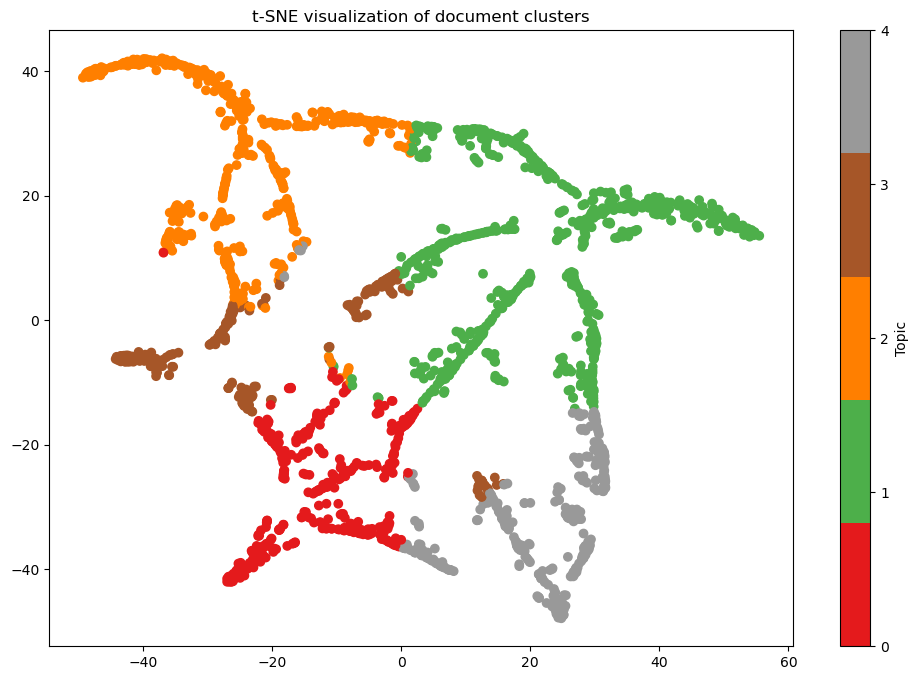


Cluster sizes:
Topic 0: 365 documents
Topic 1: 697 documents
Topic 2: 499 documents
Topic 3: 212 documents
Topic 4: 319 documents


In [46]:
plot_lda_clusters(best_lda_model, corpus)

Visualizing similarity matrix

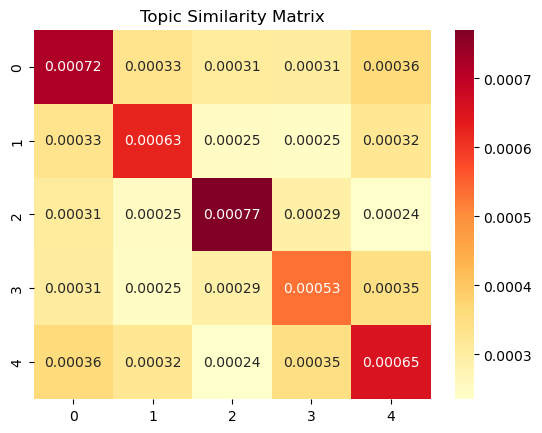

In [22]:
plot_topic_similarity(best_lda_model)

Printing topic details and top words

In [18]:
print_topic_details(best_lda_model, corpus, preprocessed_texts)

Topics and their top words:

Topic 1:
Top words: people, technology, game, show, music, service, user, use, time, site

Example documents:

Document (probability: 0.99):
fake bank email phishing story theft damaging potential using net online commerce ebusiness expert trust online security falling result almost asked poll net firm enough protect people survey people reported willing hand personal_information online worrying shopaholic firm exploit net people becoming aware online security issue little confidence company enough counter...

Document (probability: 0.99):
gambling hugely_popular especially techsavvy criminal extortionist targeting netbased betting firm threatening cripple website deluge data unless ransom paid deep defence put_place uk_biggest net firm stop attack increasing_number attack huge_amount data used try bump site web prompting firm adopt measure net firm realising antivirus_firewall paul king chief security architect cisco thing...

Document (probability: 0.99):

Results:

| Coherence Score | Silhouette Score | Perplexity |
| --------------- | ---------------- | ---------- |
| 0.5183 | 0.5853 | -8.8483 |

Analysis of the results:

The silhouette score indicates moderate separation between topics. Values above 0.5 are generally considered as a good separation, but there is room for improvement.

The coherence score measure interpretability of topics. The value 0.5193 is indicating that to topics are semantically coherent.

Lowe perplexity indicates better generalization to unseen data. Negative value is good, suggesting the model predicts new data well.

--

I have also experimented with removing different words in addition to the stopwords and not using any bigrams or trigrams. An interesting observation is that even after slightly modifying which meaningless values are removed, the number of topic clusters changes significantly. Before the model identified 19 topic clusters, but some of them were quite similar to each other. After adding a few more words to be removed, the number of topics identified reduced to 5.

The similarity matrix shows that no topic is too similar to another topic other than itself, which indicates topics are reasonably distinct from each other.